In [279]:
from __future__ import annotations
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pickle
import os
import tqdm
import matplotlib.image as mpimg

mxnet dependancies

In [191]:
import mxnet
from typing import Tuple, Union
from mxnet import nd, symbol
from mxnet.gluon.nn import HybridBlock
from mxnet.gluon.parameter import Parameter
from mxnet.initializer import Zero
from mxnet.gluon.nn import Conv2D, HybridSequential, LeakyReLU, Dense
from mxnet import nd, gluon, autograd
import mxnet as mx
from mxnet.io import NDArrayIter

facenet dependancies

In [192]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# def my_collate_fn(x):
#     return 0 # np.array(x[0])
from may import my_collate_fn 

Running on device: cpu


mxnet classes

In [193]:
def load_dataset(t, x, batch_size, shuffle=True):
    return NDArrayIter({ "x": nd.stack(*x, axis=0) }, { "t": nd.stack(*t, axis=0) }, batch_size, shuffle)

In [194]:
class Pixelnorm(HybridBlock):
    def __init__(self, epsilon: float = 1e-8) -> None:
        super(Pixelnorm, self).__init__()
        self.epsilon = epsilon

    def hybrid_forward(self, F, x) -> nd:
        return x * F.rsqrt(F.mean(F.square(x), 1, True) + self.epsilon)


class Bias(HybridBlock):
    def __init__(self, shape: Tuple) -> None:
        super(Bias, self).__init__()
        self.shape = shape
        with self.name_scope():
            self.b = self.params.get("b", init=Zero(), shape=shape)

    def hybrid_forward(self, F, x, b) -> nd:
        return F.broadcast_add(x, b[None, :, None, None])


class Block(HybridSequential):
    def __init__(self, channels: int, in_channels: int) -> None:
        super(Block, self).__init__()
        self.channels = channels
        self.in_channels = in_channels
        with self.name_scope():
            self.add(Conv2D(channels, 3, padding=1, in_channels=in_channels))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            self.add(Conv2D(channels, 3, padding=1, in_channels=channels))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())

    def hybrid_forward(self, F, x) -> nd:
        x = F.repeat(x, 2, 2)
        x = F.repeat(x, 2, 3)
        for i in range(len(self)):
            x = self[i](x)
        return x

In [195]:
class Generator(HybridSequential):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        with self.name_scope():
            self.add(Pixelnorm())
            self.add(Dense(8192, use_bias=False, in_units=512))
            self.add(Bias((512,)))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            self.add(Conv2D(512, 3, padding=1, in_channels=512))
            self.add(LeakyReLU(0.2))
            self.add(Pixelnorm())
            
            self.add(Block(512, 512)) # 8
            self.add(Block(512, 512))
            self.add(Block(512, 512))
            self.add(Block(256, 512))
            self.add(Block(128, 256))
            self.add(Block(64, 128))
            self.add(Block(32, 64))
            self.add(Block(16, 32)) # 15
            self.add(Conv2D(3, 1, in_channels=16))


    def hybrid_forward(self, F: Union(nd, symbol), x: nd, layer: int) -> nd:
        x = F.Reshape(self[1](self[0](x)), (-1, 512, 4, 4))
        for i in range(2, len(self)):
            x = self[i](x)
            if i == layer + 7:
              return x
        return x

## new classes!

In [249]:
class Linear(HybridSequential):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        with self.name_scope():
            self.add(Dense(n_out, in_units=n_in))
            
class LinearNoBias(HybridSequential):
    def __init__(self, n_in, n_out):
        super(LinearNoBias, self).__init__()
        with self.name_scope():
            self.add(Dense(n_out, in_units=n_in, use_bias = False))

class LinearNew(HybridSequential):
    def __init__(self, n_in, n_out):
        super(LinearNew, self).__init__()
        with self.name_scope():
            #self.add(Dense(n_out, in_units=n_in))
            self.add(Dense(600, in_units = n_in, activation='relu'))
            self.add(Dense(n_out))

class Sigmoid(HybridSequential):
    def __init__(self, n_in, n_out):
        super(Sigmoid, self).__init__()
        with self.name_scope():
            self.add(Dense(n_out, in_units = n_in, activation='sigmoid'))
            
class softRelu(HybridSequential):
    def __init__(self, n_in, n_out):
        super(softRelu, self).__init__()
        with self.name_scope():
            self.add(Dense(n_out, in_units = n_in, activation='softrelu'))            
           
            

In [260]:
class cnn2DImage(HybridSequential):
    def __init__(self, n_in, n_out):
        super(cnn2DImage, self).__init__()
        with self.name_scope():
            self.add(Conv2D(n_out, kernel_size= (3,3)))

class cnn3DImage(HybridSequential):
    def __init__(self, n_in, n_out):
        super(cnn3DImage, self).__init__()
        with self.name_scope():
            self.add(Conv3D(n_out, kernel_size = 3))

class rnn(HybridSequential):
    def __init__(self, n_in, n_out):
        super(rnn, self).__init__()
        with self.name_scope():
            self.add(rnn(n_out, in_units=n_in))

                     
                     

In [252]:
class LinearNew(HybridSequential):
    def __init__(self, n_in, n_out):
        super(LinearNew, self).__init__()
        with self.name_scope():
            self.add(Dense(600, in_units = n_in, activation='relu'), Dense(n_out))



In [274]:
class Linear3(HybridSequential):
    def __init__(self, n_in, n_out):
        super(Linear3, self).__init__()
        with self.name_scope():
            self.add(Dense(1000, in_units = n_in), Dense(550), Dense(n_out))

class Linear4(HybridSequential):
    def __init__(self, n_in, n_out):
        super(LinearNew, self).__init__()
        with self.name_scope():
            self.add(Dense(3000, in_units = n_in),  Dense(2000), Dense(1000), Dense(n_out))



In [275]:
n_vox = 4096
n_lat = 512

# main code

In [273]:
def modelRun(model, max_epoch, batch_size, currentDic):

    generator = Generator()
    generator.load_parameters(os.getcwd() + "/data/generator.params")
    mean_squared_error = gluon.loss.L2Loss()

    for subject in [1]:
          # Data
        with open((os.getcwd() + "/data/data_%i.dat") % subject, 'rb') as f:
              X_tr, T_tr, X_te, T_te = pickle.load(f)
        train = load_dataset(nd.array(T_tr), nd.array(X_tr), batch_size)        
        test =  load_dataset(nd.array(T_te), nd.array(X_te), batch_size=36, shuffle=False)  

          # Training
        print("modelName" , model)
        vox_to_lat = Linear(n_vox, n_lat)
        if (model == 1):
            vox_to_lat = LinearNoBias(n_vox, n_lat)     
        if (model == 2):
            vox_to_lat = LinearNew(n_vox, n_lat)
        if (model == 3):
            vox_to_lat = Sigmoid(n_vox, n_lat)
        if (model == 4):
            vox_to_lat = softRelu(n_vox, n_lat)
        if (model == 5):
            vox_to_lat = cnn2DImage( n_vox, n_lat)
        if (model == 6):
            vox_to_lat = cnn3DImage(n_vox, n_lat)
        if (model == 7):
            vox_to_lat = rnn(n_vox, n_lat)
        if (model == 8):
            vox_to_lat = Linear3(n_vox, n_lat)
        if (model == 9):
            vox_to_lat = Linear4(n_vox, n_lat)
                    
            
        vox_to_lat.initialize()
        trainer = gluon.Trainer(vox_to_lat.collect_params(), "Adam", {"learning_rate": 0.00001, "wd": 0.01})
    #       epoch = 0
        results_tr = []
        results_te = []
        for epoch in tqdm.tqdm(range(max_epoch)):
            train.reset()
            test.reset()
            loss_tr = 0
            loss_te = 0
            count = 0
            for batch_tr in train:
                with autograd.record():
                    lat_Y = vox_to_lat(batch_tr.data[0])
                    #lat_Y = vox_to_lat(batch_size, batch_tr.data[0] )
                    loss = mean_squared_error(lat_Y, batch_tr.label[0])
                loss.backward()
                trainer.step(batch_size)
                loss_tr += loss.mean().asnumpy()
                count += 1
            for batch_te in test:
                lat_Y = vox_to_lat(batch_te.data[0])
                loss = mean_squared_error(lat_Y, batch_te.label[0])
                loss_te += loss.mean().asnumpy()
            loss_tr_normalized = loss_tr / count
            results_tr.append(loss_tr_normalized)
            results_te.append(loss_te)
            epoch += 1

        fig2, ax2 = plt.subplots()
        ax2.plot(np.linspace(0, epoch, epoch), results_tr)
        ax2.plot(np.linspace(0, epoch, epoch), results_te)
        fig2.savefig( currentDic + "/loss_s.png")
            
    
          # Testing and reconstructing
        lat_Y = vox_to_lat(nd.array(X_te))
            
        pickle.dump(lat_Y, open(currentDic + "/lat_Y.pkl", "wb"))
    
    return lat_Y   


In [204]:
def generate_from_latent(lat):
    faces = []
    for i, latent in enumerate(lat):
        face = generator(latent[None], 9).asnumpy()
        face = np.clip(np.rint(127.5 * face + 127.5), 0.0, 255.0)
        face = face.astype("uint8")
        face = face.transpose(0, 2, 3, 1)
        faces.append(face)
    return faces

In [205]:
def moveAndGenerate(lat_Y):
    img_pred = generate_from_latent(lat_Y)
    for idx in range(36):
        Image.fromarray(img_pred[idx][0], 'RGB').save(f"{currentDir}/facesV1/face_%d/1.jpg" % idx)
     

In [206]:
def test():
    
    dataset = datasets.ImageFolder(f'{currentDir}/facesV1')
    dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
    loader = DataLoader(dataset, collate_fn=my_collate_fn, num_workers=workers)
    
    aligned = []
    names = []
    for x, y in loader:
        x_aligned, prob = mtcnn(x, return_prob=True)
        if x_aligned is not None:
            aligned.append(x_aligned)
            names.append(dataset.idx_to_class[y])
            
    return aligned, names
    # loader = DataLoader(dataset, num_workers=workers)

In [207]:
def faceNetTry():
    aligned, names = test()
    aligned = torch.stack(aligned).to(device)
    embeddings = resnet(aligned).detach().cpu()
    
    dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
    distsDF = pd.DataFrame(dists, columns=names, index=names)
    return distsDF


In [215]:
def dataCollection(distsDF, currentDict):
    os.chdir(currentDict)
    
    distsDiff = []
    
    for i in range(36): 
        face1 = ("face_%d" % i)
        face2 = ("face_gt_%d" % i)

        with open('distAll.txt', 'a') as f:
            f.write(f"{face1},{face2},{distsDF[face1][face2]}")
        
        distsDiff.append(distsDF[face1][face2])
    
    with open('distSum.txt', 'w') as f:
        f.write(f"avg distance = {str(np.mean(distsDiff))}")
                
    fig1, ax1 = plt.subplots()
    ax1.plot(distsDiff, marker = 'o', linestyle = "--")            
    fig1.savefig('distsDiff.jpg')
                
    return distsDiff

In [216]:
def savePhotoComp(distsDF, currentDict):
    os.chdir(currentDict)
    fig, axes = plt.subplots(35,2,figsize=(10,200))
    k = 0;
    for i in range(35):
        img = (f"{currentDir}/facesV1/face_gt_%d/1.jpg" % i) 
        axes.ravel()[k].imshow(mpimg.imread(img))   
        img = (f"{currentDir}/facesV1/face_%d/1.jpg" % i)   
        axes.ravel()[k + 1].imshow(mpimg.imread(img))  

        face1 = ("face_%d" % i)
        face2 = ("face_gt_%d" % i)
        axes.ravel()[k].text(1000, -30, distsDF[face1][face2], fontsize=12)
        k += 2

    plt.savefig('comparision.jpg')

## MAIN

In [277]:
classes = [8,9]
epochs = [900,1200]#exclude 900, 1200
batch_sizes = [30] 

In [335]:
os.chdir('/Users/maylevin/Desktop/neuro/HYPER-master')

In [336]:
#decide on current directory to put files in
currentDir = '/Users/maylevin/Desktop/neuro/HYPER-master'

In [ ]:

for modelName in classes:
    for max_epoch in epochs:
        for batch_size in batch_sizes:
            os.chdir(currentDir)
            !mkdir /Users/maylevin/Desktop/neuro/HYPER-master/models/{modelName}_{max_epoch}_{batch_size}
            cwd = f"{currentDir}/models/{modelName}_{max_epoch}_{batch_size}"
            
            lat_Y = modelRun(modelName, max_epoch, batch_size, cwd)
            moveAndGenerate(lat_Y)
            distsDF = faceNetTry()
            distsDiff = dataCollection(distsDF, cwd)
            savePhotoComp(distsDF, cwd)
            
            print(f"{modelName}_{max_epoch}_{batch_size} has avg. similarity of {np.mean(distsDiff)}")
            
            modelArray = modelArray.append({'modelName' : f"{modelName}_{max_epoch}_{batch_size}" , 'distsDiff' : np.mean(distsDiff)}, ignore_index = True)
 

        

In [322]:
modelArray = pd.DataFrame(columns=['modelName','distsDiff'])

In [337]:
for i in os.listdir(f'{currentDir}/models'):
    if(i != ".DS_Store"):
        with open(f"{currentDir}/models/{i}/distSum.txt") as f:
            lines = f.readlines()
            modelArray = modelArray.append({'modelName' : i , 'distsDiff' : float(lines[0].split('=')[1])}, ignore_index = True)
 

/var/folders/wm/wmrhks9s2dl_1lyyjt_2kvn40000gn/T/ipykernel_10047/1956757291.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modelArray = modelArray.append({'modelName' : i , 'distsDiff' : float(lines[0].split('=')[1])}, ignore_index = True)
/var/folders/wm/wmrhks9s2dl_1lyyjt_2kvn40000gn/T/ipykernel_10047/1956757291.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modelArray = modelArray.append({'modelName' : i , 'distsDiff' : float(lines[0].split('=')[1])}, ignore_index = True)
/var/folders/wm/wmrhks9s2dl_1lyyjt_2kvn40000gn/T/ipykernel_10047/1956757291.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  modelArray = modelArray.append({'modelName' : i , 'distsDiff' : float(lines[0].split('=')[1])}, ignore_index = True

In [333]:
modelArray.sort_values("distsDiff")

,modelName,distsDiff
0,1_1500_30,1.132379
4,0_1500_30,1.143644
21,1_700_30,1.143913
17,0_900_30,1.148636
13,0_700_30,1.153088
10,0_1200_30,1.159802
12,1_1200_30,1.169655
5,1_900_30,1.177605
16,2_900_30,1.352438
7,2_700_30,1.354133


In [331]:
modelArray = modelArray.sort_values("modelName")

<AxesSubplot:xlabel='modelName'>

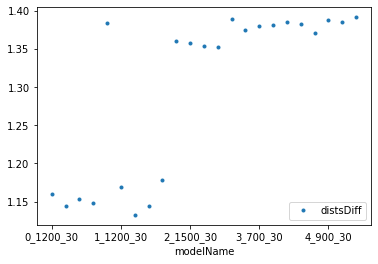

In [332]:
modelArray.plot(kind = "line", style='.', x = "modelName")